# Fitting power laws for homophones and minimal pairs

In [1]:
import math
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import seaborn as sns

from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from tqdm import tqdm

import src.utils as utils
import src.config as config

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

# Helper functions

In [3]:
NUM_ARTIFICIAL = 10

In [4]:
def get_stats_for_lexicon(df_lex):
    """Return basic stats about lexicon. Number of homophones, etc."""
    return {'homophone_percentage': round((len(df_lex[df_lex['num_homophones']>0]) / len(df_lex)), 4),
            'mean_homophones': round(df_lex['num_homophones'].mean(), 4),
            'max_homophones': round(df_lex['num_homophones'].max(), 2),
            'mean_mp': round(df_lex['neighborhood_size'].mean(), 4),
            'max_mp': round(df_lex['neighborhood_size'].max(), 2),
            'total_mp': round(df_lex['neighborhood_size'].sum(), 2),
            'mean_mp_w_hp': round(df_lex['neighborhood_size_with_homophones'].mean(), 4),
            'max_mp_w_hp': round(df_lex['neighborhood_size_with_homophones'].max(), 2),
            'total_mp_w_hp': round(df_lex['neighborhood_size_with_homophones'].sum(), 2)}

def load_lexicons_for_language(language, phon_column="PhonDISC", word_column="Word", nphones=5):
    """Loads lexicons for a given language."""
    if language == "mandarin":
        df_real = pd.read_csv("data/processed/{lan1}/minimal_pairs/{lan2}_all_mps_{n}phone.csv".format(lan1=language,
                                                                                             lan2=language, n=nphones))
        df_real_processed = utils.preprocess_for_analysis(df_real, word_column=word_column, phon_column=phon_column)
        df_artificials = pd.read_csv("data/processed/{lan1}/minimal_pairs/{lan2}_artificial_10_matched_on_sylls_mps_no_restriction_{n}phone.csv".format(lan1=language,
                                                                                                                      lan2=language, n=nphones))
    else:
        df_real = pd.read_csv("data/processed/{lan1}/minimal_pairs/{lan2}_all_mps.csv".format(lan1=language, lan2=language))
        df_real_processed = utils.preprocess_for_analysis(df_real, word_column=word_column, phon_column=phon_column)
        df_artificials = pd.read_csv("data/processed/{lan1}/minimal_pairs/{lan2}_artificial_10_matched_on_sylls_mps_no_restriction.csv".format(lan1=language,
                                                                                                                           lan2=language))
    return df_real, df_real_processed, df_artificials

def process_and_extract_artificials(df_artificials, N=10, remove=True):
    """Extract each artificial lexicon from aggregated dataframe.
    
    Also returns information about homophony distribution and minimal pair distribution.
    """
    processed_artificials = []
    homophone_percentages = []
    mean_homophones, max_homophones = [], []
    mean_mp, max_mp, total_mp = [], [], []
    # Neighborhood size with homophones
    mean_mp_hp, max_mp_hp, total_mp_hp = [], [], []
    for i in tqdm(range(N)):

        df_tmp = df_artificials[df_artificials['lexicon']==i]

        df_tmp_processed = utils.preprocess_for_analysis(df_tmp, verbose=False,
                                                          phon_column="word", word_column="word", remove=remove)
        
        lex_stats = get_stats_for_lexicon(df_tmp_processed)

        homophone_percentages.append(lex_stats['homophone_percentage'])
        mean_homophones.append(lex_stats['mean_homophones'])
        max_homophones.append(lex_stats['max_homophones'])
        mean_mp.append(lex_stats['mean_mp'])
        max_mp.append(lex_stats['max_mp'])
        total_mp.append(lex_stats['total_mp'])
        mean_mp_hp.append(lex_stats['mean_mp_w_hp'])
        max_mp_hp.append(lex_stats['max_mp_w_hp'])
        total_mp_hp.append(lex_stats['total_mp_w_hp'])
                
        processed_artificials.append(df_tmp_processed)
    
    return {'processed_dataframes': processed_artificials,
            'homophone_percentage': homophone_percentages,
            'mean_homophones': mean_homophones,
            'max_homophones': max_homophones,
            'mean_mp': mean_mp,
            'max_mp': max_mp,
            'total_mp': total_mp,
            'mean_mp_w_hp': mean_mp_hp,
            'max_mp_w_hp': max_mp_hp,
            'total_mp_w_hp': total_mp_hp
           }

# Power-law functions

**Note**: Determine whether these are the correct formulations of Zipf's law, etc.

On the other hand, whether it's the correct formulation of Zipf's law may not matter if what we really want is to compare the parameters.

For `f(x) = (a/x**b)`:

- `a` is the scaling constant, and corresponds to the y-value when x=1. This will determine how high up the curve starts. Larger `a` --> higher on the y-axis.
- `b` determines the rate at which the curve decreases. Larger `b` --> faster rate of decreasing.

For `f(x) = (a/x**b) * c`:

- `a` and `c` are both scaling constants. If `a==c`, this is just equivalent to the formula above. Otherwise, `c` basically acts in a way analogous to `a`: larger values of `c` means the curve starts higher up on the y-axis. 
- `b` still determines the rate at which the curve decreases. Larger `b` --> faster rate of decreasing. 

In [5]:
def zipf_func(x, a, b):
    """Zipf's law."""
    return a / (x**b)

def yule_simon_func(x, a, b, c):
    """Yule-Simon distribution."""
    return (a / (x**b)) * c**x

In [6]:
def zipf_func(x, a, b):
    """Zipf's law. Assume log-distributed y."""
    return np.log(a) - (b*np.log(x))

def yule_simon_func(x, a, b, c):
    """Yule-Simon distribution."""
    return (a / (x**b)) * c**x

In [7]:
## TODO: Modify characterize_powerlaw to be specific to either Zipf or YS. 

In [8]:
def fit_law(x, y, func):
    """Fit specified function."""
    # Fit function
    z_popt, z_pcov = curve_fit(func, x, y)
    
    # Generate predictions
    z_pred = func(x, *z_popt)
    
    # Characterize fit with R^2
    r2 = r2_score(y, z_pred)
    
    return z_popt, z_pcov, z_pred, r2

In [9]:
def characterize_zipf_law(x, y, real):
    """Use func to characterize powerlaw."""
    
    z_popt, z_pcov, z_pred, r2 = fit_law(x, y, zipf_func)
    
    a, b = z_popt
    
    # Return fit, along with parameters
    return [{'r2': r2,
           'real': real,
            'a': a,
            'b': b}, 
            z_pred]

def characterize_ys_law(x, y, real):
    """Use func to characterize powerlaw."""
    
    z_popt, z_pcov, z_pred, r2 = fit_law(x, y, yule_simon_func)
    
    a, b, c = z_popt
    
    # Return fit, along with parameters
    return [{'r2': r2,
           'real': real,
            'a': a,
            'b': b,
            'c': c}, 
            z_pred]

In [10]:
rank_N = 1000

# English

In [11]:
df_main, df_main_processed, df_english_artificials = load_lexicons_for_language("english")

Number of tokens: 52437
Number of tokens: 41887


/Users/seantrott/Dropbox/UCSD/Research/Ambiguity/Evolution/homophone_simulations/src/utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['remove'] = df[word_column].apply(remove_word)


Number of tokens: 35107


In [12]:
info_for_english = process_and_extract_artificials(df_english_artificials)
processed_artificials = info_for_english['processed_dataframes']

100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


## `Frequency ~ rank_frequency`

Sanity check: this should follow Zipf's law.

In [289]:
df_main_processed['rank_frequency'] = df_main_processed['CobLog'].rank(ascending=False, method="first")
df_main_processed = df_main_processed.sort_values(by = 'rank_frequency')

In [290]:
top_n = df_main_processed[df_main_processed['rank_frequency'] < rank_N]
x, y = top_n['rank_frequency'], top_n['CobLog']

In [291]:
real_params, real_preds = characterize_zipf_law(x, y, real=True)

In [170]:
real_params

{'r2': 0.9837774520085045,
 'real': True,
 'a': 5.438558115499437,
 'b': 0.15490864000367682}

Text(0.5, 0, 'Rank frequency')

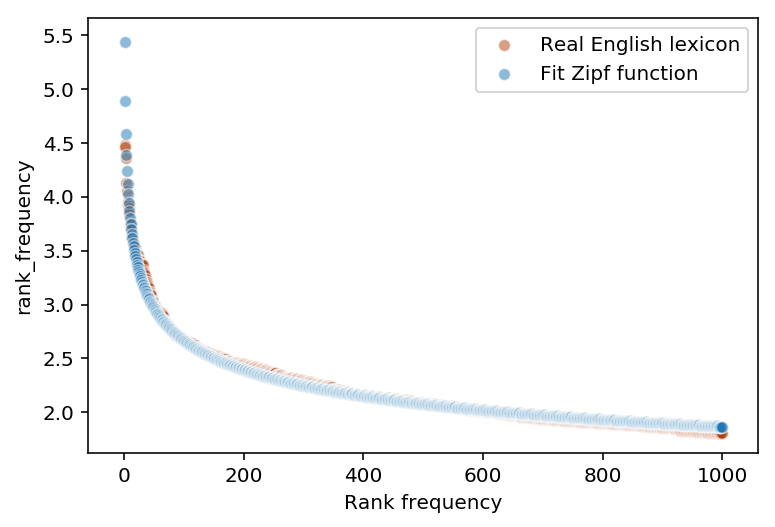

In [171]:
sns.scatterplot(x = x,
                y = y, 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real English lexicon")

sns.scatterplot(x = x, 
                y = real_preds,
                alpha = .5,
                label = "Fit Zipf function")

plt.xlabel("Rank frequency")
# plt.ylabel("Log(frequency)")

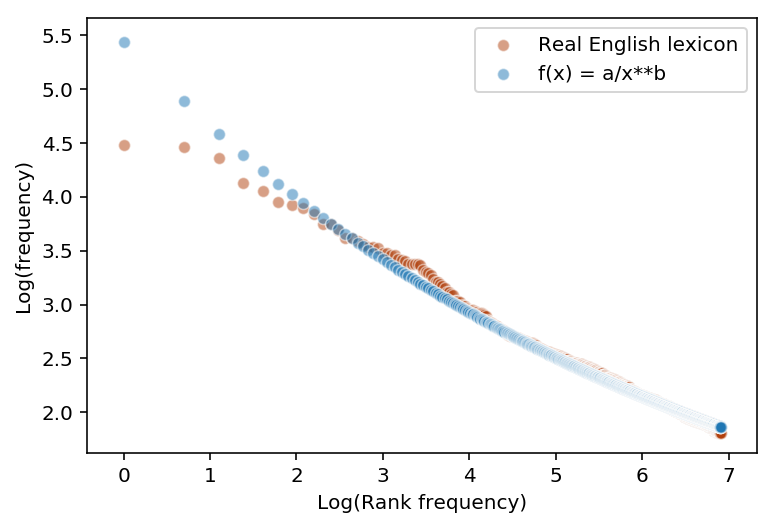

In [172]:
sns.scatterplot(x = [math.log(i) for i in x],
                y = y, 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real English lexicon")

sns.scatterplot(x = [math.log(i) for i in x], 
                y = real_preds,
                alpha = .5,
                label = "f(x) = a/x**b")

plt.xlabel("Log(Rank frequency)")
plt.ylabel("Log(frequency)")

plt.savefig("Figures/powerlaw/english_zipf_frequency.png", dpi=300)

## `#homophones ~ rank_homophones`

In [13]:
rank_N = 1000

In [14]:
tops = []
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_homophones'] = df_tmp_art['num_homophones'].rank(ascending=False, method="first")
    top_n = sorted(df_tmp_art[df_tmp_art['rank_homophones']<=rank_N]['num_homophones'].values, reverse=True)
    tops.append(top_n)
stats = []
for n in range(rank_N):
    stats.append({
        'rank_homophones': n + 1,
        'num_homophones': np.median([i[n] for i in tops])
    })
df_stats = pd.DataFrame(stats)

Text(0.5, 1.0, 'English: #Homophones by rank')

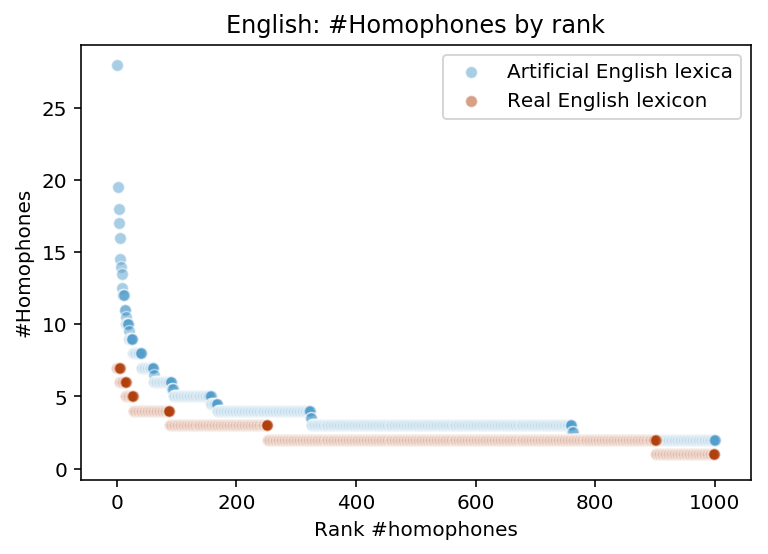

In [15]:
sns.scatterplot(data = df_stats,
               x = "rank_homophones",
               y = "num_homophones", 
                color = sns.color_palette("Blues")[3],
                alpha = .5,
                label = "Artificial English lexica")

df_main_processed['rank_homophones'] = df_main_processed['num_homophones'].rank(ascending=False, method="first")
sns.scatterplot(data = df_main_processed[df_main_processed['rank_homophones']<rank_N],
               x = "rank_homophones",
               y = "num_homophones", 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real English lexicon")
plt.xlabel("Rank #homophones")
plt.ylabel("#Homophones")
plt.title("English: #Homophones by rank")

### Characterize power laws

#### Zipf

In [16]:
# df_main_processed['num_homophones'] = df_main_processed['num_homophones'].apply(lambda x: x + 1)

In [17]:
top_n = df_main_processed[df_main_processed['rank_homophones'] < rank_N]
x, y = top_n['rank_homophones'], top_n['num_homophones']

In [18]:
y_log = [np.log(i) for i in y]

In [19]:
real_fit, real_preds = characterize_zipf_law(x, y_log, real=True)

Text(0, 0.5, 'Log(#homophones)')

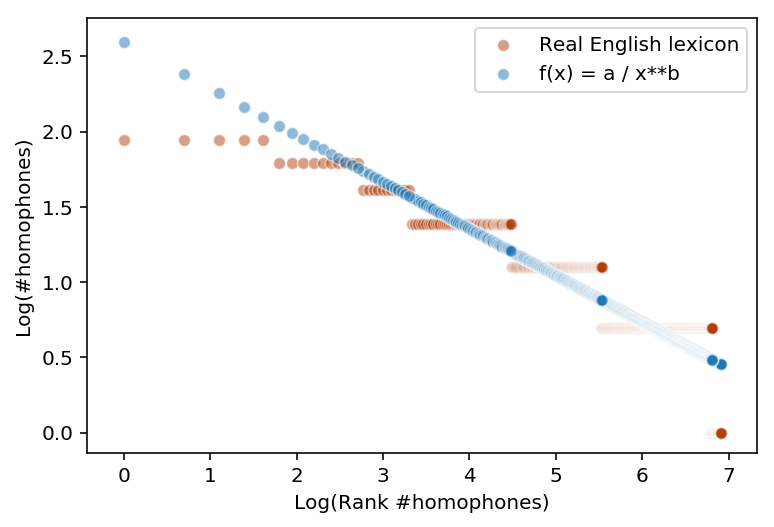

In [20]:
sns.scatterplot(x = [math.log(i) for i in x],
               y = y_log, 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real English lexicon")

sns.scatterplot(x = [math.log(i) for i in x], 
                y = real_preds,
               alpha = .5,
               label = "f(x) = a / x**b")

plt.xlabel("Log(Rank #homophones)")
plt.ylabel("Log(#homophones)")

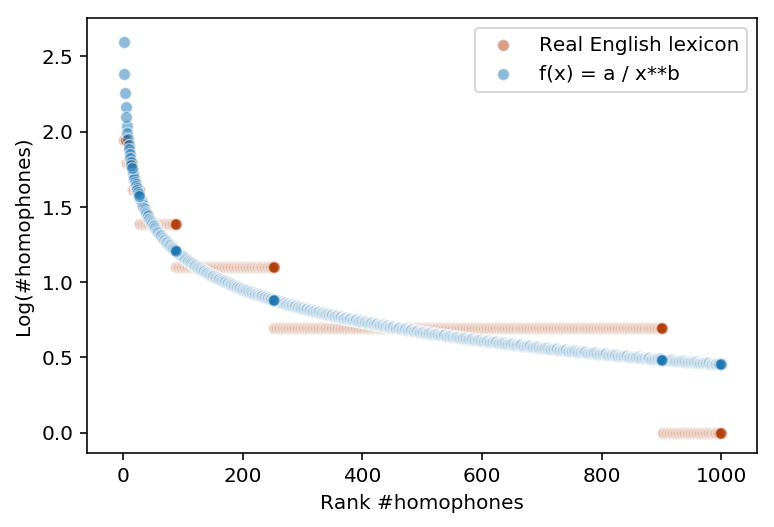

In [22]:
sns.scatterplot(x = x,
               y = y_log, 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real English lexicon")

sns.scatterplot(x = x, 
                y = real_preds,
               alpha = .5,
               label = "f(x) = a / x**b")

plt.xlabel("Rank #homophones")
plt.ylabel("Log(#homophones)")

plt.savefig("Figures/powerlaw/english_zipf_homophones.png", dpi=300)

In [23]:
zipf_info = [real_fit]

In [24]:
for art in processed_artificials:
    top = art[art['rank_homophones'] < rank_N]
    x, y = top['rank_homophones'], top['num_homophones']
    y_log = [np.log(i) for i in y]
    fit, preds = characterize_zipf_law(x, y_log, real=False)
    zipf_info.append(fit)

In [25]:
df_fit = pd.DataFrame(zipf_info)

/Users/seantrott/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


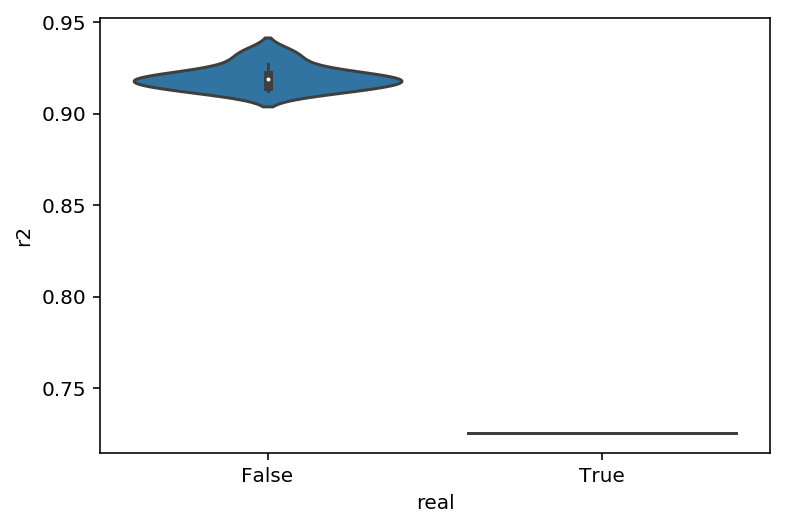

In [26]:
sns.violinplot(data = df_fit,
               x = 'real',
               y = 'r2')

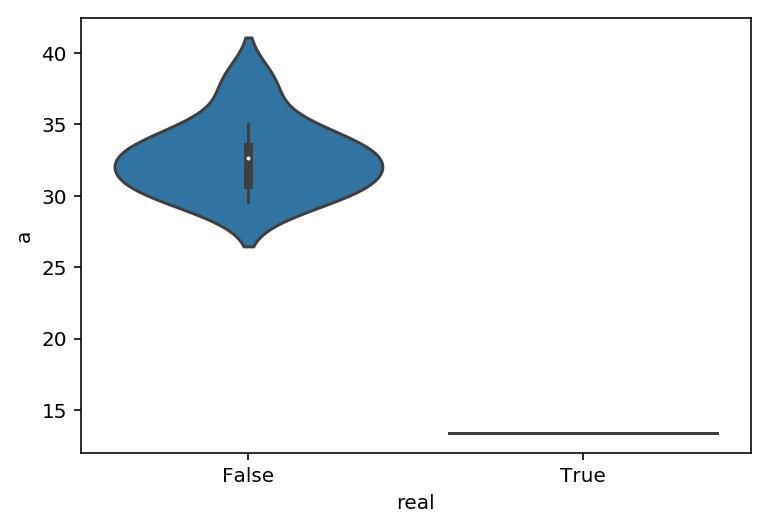

In [74]:
sns.violinplot(data = df_fit,
               x = 'real',
               y = 'a')

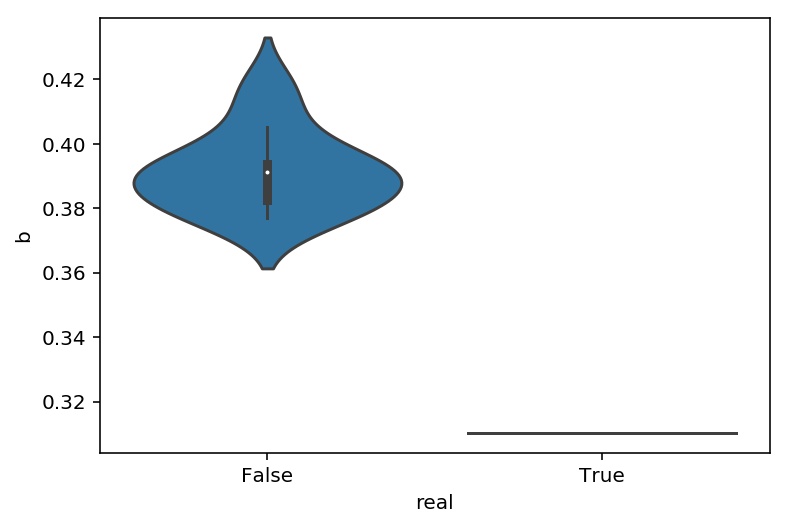

In [75]:
sns.violinplot(data = df_fit,
               x = 'real',
               y = 'b')

## `#minimal pairs ~ rank #minimal pairs`

In [27]:
rank_N = 1000

In [28]:
tops = []
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_mps'] = df_tmp_art['neighborhood_size'].rank(ascending=False, method="first")
    top_n = sorted(df_tmp_art[df_tmp_art['rank_mps']<=rank_N]['neighborhood_size'].values, reverse=True)
    tops.append(top_n)
stats = []
for n in range(rank_N):
    stats.append({
        'rank_mps': n + 1,
        'neighborhood_size': np.median([i[n] for i in tops])
    })
df_stats = pd.DataFrame(stats)

Text(0.5, 1.0, 'English: #minimal pairs by rank')

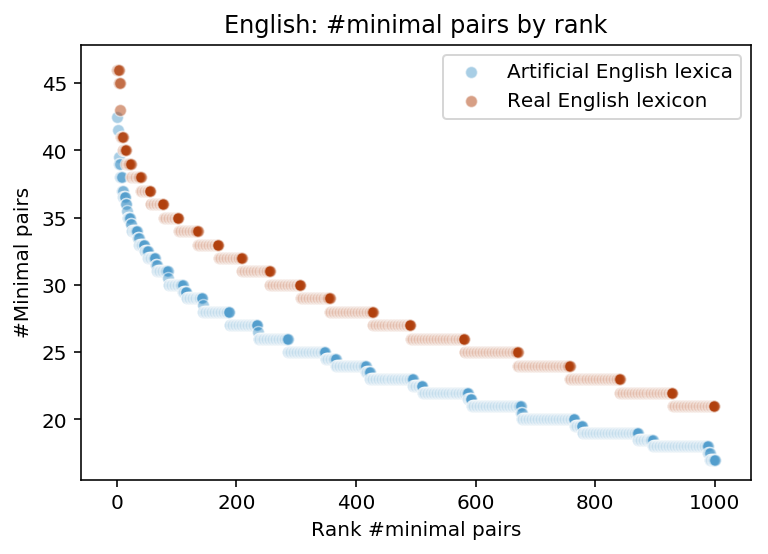

In [29]:
sns.scatterplot(data = df_stats,
               x = "rank_mps",
               y = "neighborhood_size", 
                color = sns.color_palette("Blues")[3],
                alpha = .5,
                label = "Artificial English lexica")

df_main_processed['rank_mps'] = df_main_processed['neighborhood_size'].rank(ascending=False, method="first")
sns.scatterplot(data = df_main_processed[df_main_processed['rank_mps']<rank_N],
               x = "rank_mps",
               y = "neighborhood_size", 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real English lexicon")
plt.xlabel("Rank #minimal pairs")
plt.ylabel("#Minimal pairs")
plt.title("English: #minimal pairs by rank")

### Characterize power laws

#### Zipf

In [30]:
top_1000 = df_main_processed[df_main_processed['rank_mps'] < rank_N]
x, y = top_1000['rank_mps'], top_1000['neighborhood_size']

In [31]:
y_log = [np.log(i) for i in y]

In [32]:
real_fit, real_preds = characterize_zipf_law(x, y_log, real=True)

Text(0, 0.5, 'Log(#minimal pairs)')

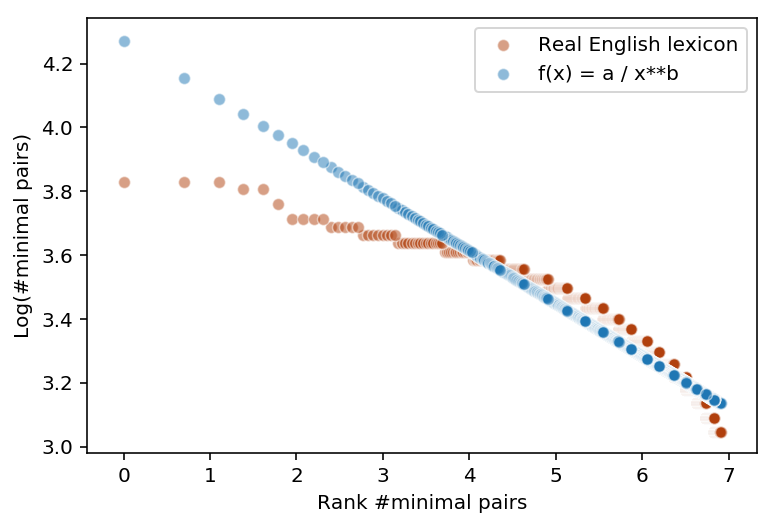

In [33]:
sns.scatterplot(x = [np.log(i) for i in x],
               y = y_log, 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real English lexicon")

sns.scatterplot(x = [np.log(i) for i in x], 
                y = real_preds,
               alpha = .5,
               label = "f(x) = a / x**b")

plt.xlabel("Rank #minimal pairs")
plt.ylabel("Log(#minimal pairs)")

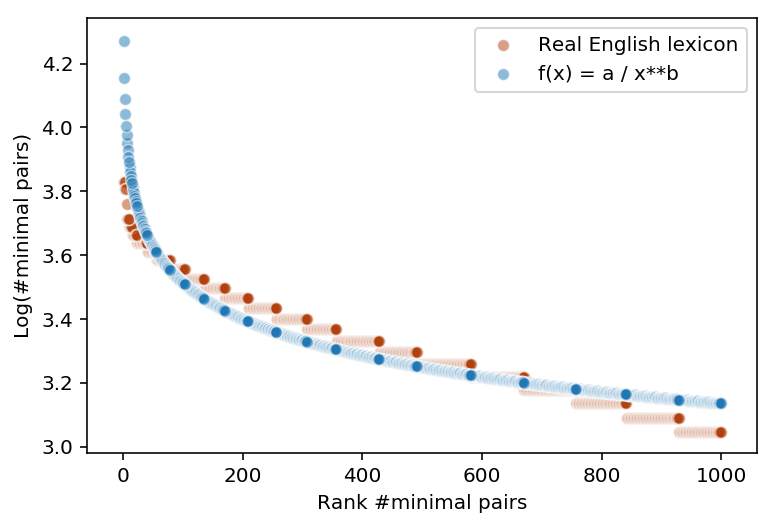

In [35]:
sns.scatterplot(x = x,
               y = y_log, 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real English lexicon")

sns.scatterplot(x = x, 
                y = real_preds,
               alpha = .5,
               label = "f(x) = a / x**b")

plt.xlabel("Rank #minimal pairs")
plt.ylabel("Log(#minimal pairs)")

plt.savefig("Figures/powerlaw/english_zipf_mps.png", dpi=300)

In [47]:
zipf_info = [real_fit]

In [48]:
for art in processed_artificials:
    top = art[art['rank_mps'] < rank_N]
    x, y = top['rank_mps'], top['neighborhood_size']
    y_log = [np.log(i) for i in y]
    fit, preds = characterize_zipf_law(x, y_log, real=False)
    zipf_info.append(fit)

In [49]:
df_fit = pd.DataFrame(zipf_info)

/Users/seantrott/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


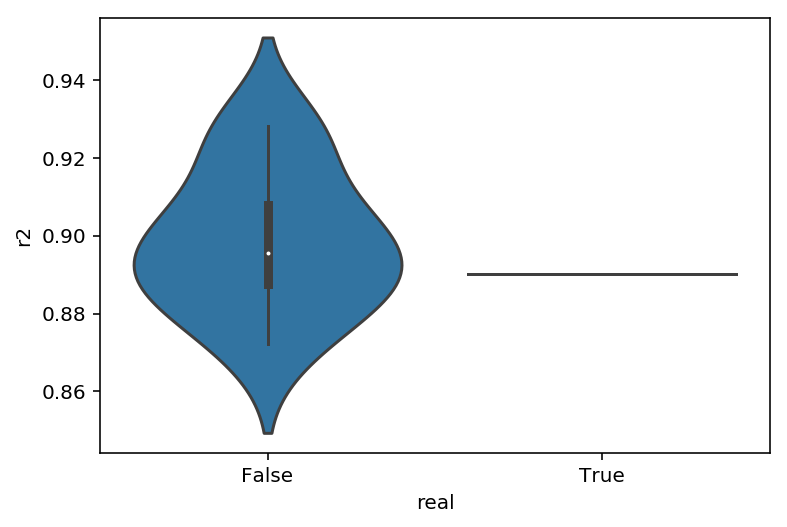

In [50]:
sns.violinplot(data = df_fit,
               x = 'real',
               y = 'r2')

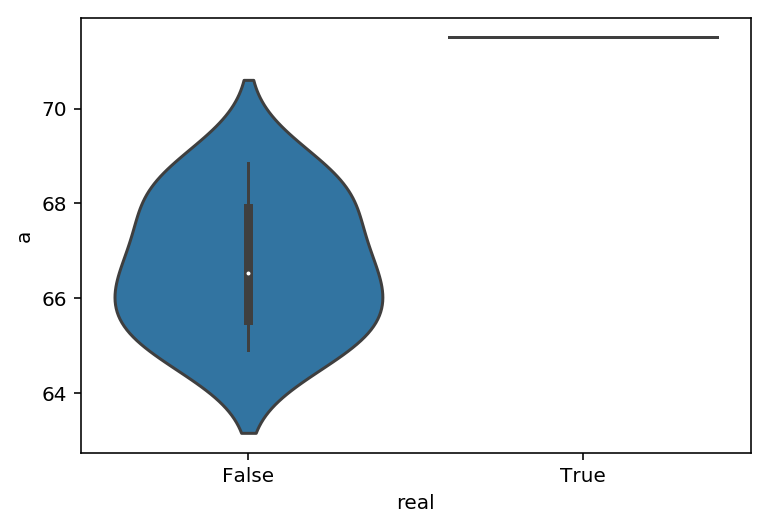

In [51]:
sns.violinplot(data = df_fit,
               x = 'real',
               y = 'a')

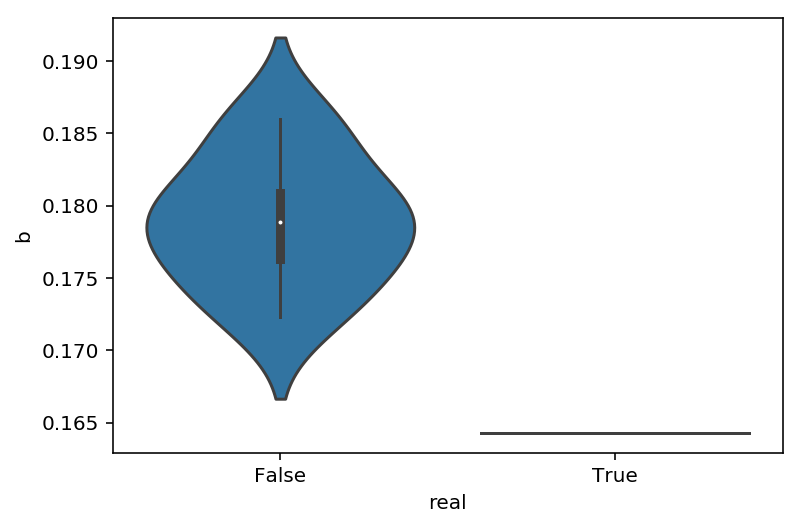

In [52]:
sns.violinplot(data = df_fit,
               x = 'real',
               y = 'b')

# Japanese

In [203]:
df_main, df_main_processed, df_japanese_artificials = load_lexicons_for_language("japanese", phon_column="phonetic_remapped",
                                                                                 word_column="orth_form_romaji")

Number of tokens: 51147
Number of tokens: 51147
Number of tokens: 40449


In [204]:
info_for_japanese = process_and_extract_artificials(df_japanese_artificials)
processed_artificials = info_for_japanese['processed_dataframes']

100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


## `Frequency ~ rank_frequency`

Sanity check: this should follow Zipf's law.

In [207]:
df_main_processed['rank_frequency'] = df_main_processed['frequency'].rank(ascending=False, method="first")
df_main_processed = df_main_processed.sort_values(by = 'rank_frequency')

In [208]:
top_n = df_main_processed[df_main_processed['rank_frequency'] < rank_N]
x, y = top_n['rank_frequency'], top_n['frequency']

In [209]:
real_params, real_preds = characterize_zipf_law(x, y, real=True)

In [210]:
real_params

{'r2': 0.9635469103286728,
 'real': True,
 'a': 10949.16774898795,
 'b': 0.8343986095333619}

Text(0, 0.5, 'Frequency')

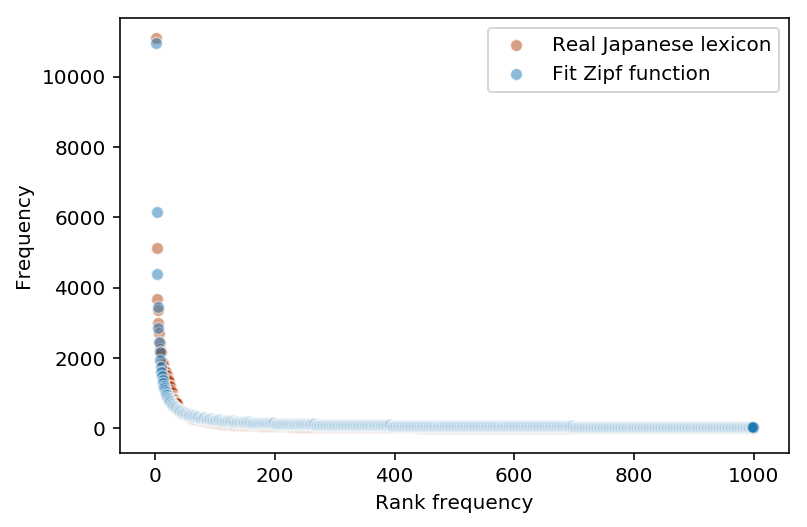

In [213]:
sns.scatterplot(x = x,
                y = y, 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real Japanese lexicon")

sns.scatterplot(x = x, 
                y = real_preds,
                alpha = .5,
                label = "Fit Zipf function")

plt.xlabel("Rank frequency")
plt.ylabel("Frequency")

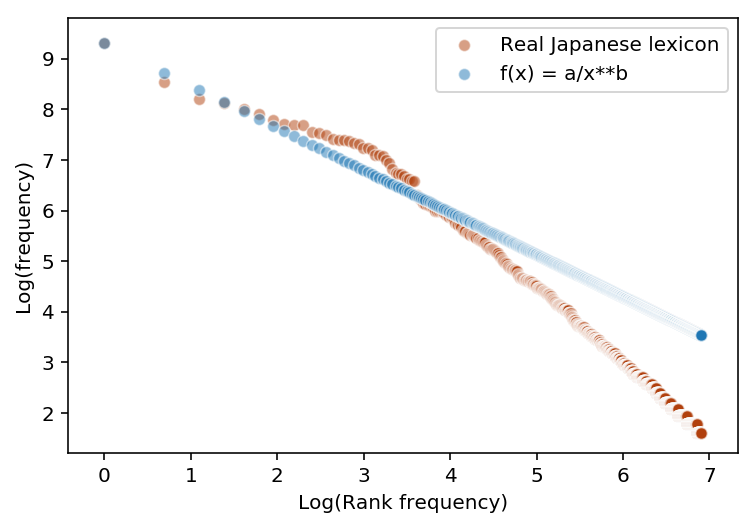

In [217]:
sns.scatterplot(x = [math.log(i) for i in x],
                y = [math.log(i) for i in y], 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real Japanese lexicon")

sns.scatterplot(x = [math.log(i) for i in x], 
                y = [math.log(i) for i in real_preds],
                alpha = .5,
                label = "f(x) = a/x**b")

plt.xlabel("Log(Rank frequency)")
plt.ylabel("Log(frequency)")

plt.savefig("Figures/powerlaw/japanese_zipf_frequency.png", dpi=300)

## `#homophones ~ rank_homophones`

In [218]:
rank_N = 1000

In [219]:
tops = []
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_homophones'] = df_tmp_art['num_homophones'].rank(ascending=False, method="first")
    top_n = sorted(df_tmp_art[df_tmp_art['rank_homophones']<=rank_N]['num_homophones'].values, reverse=True)
    tops.append(top_n)
stats = []
for n in range(rank_N):
    stats.append({
        'rank_homophones': n + 1,
        'num_homophones': np.median([i[n] for i in tops])
    })
df_stats = pd.DataFrame(stats)

Text(0.5, 1.0, 'Japanese: #Homophones by rank')

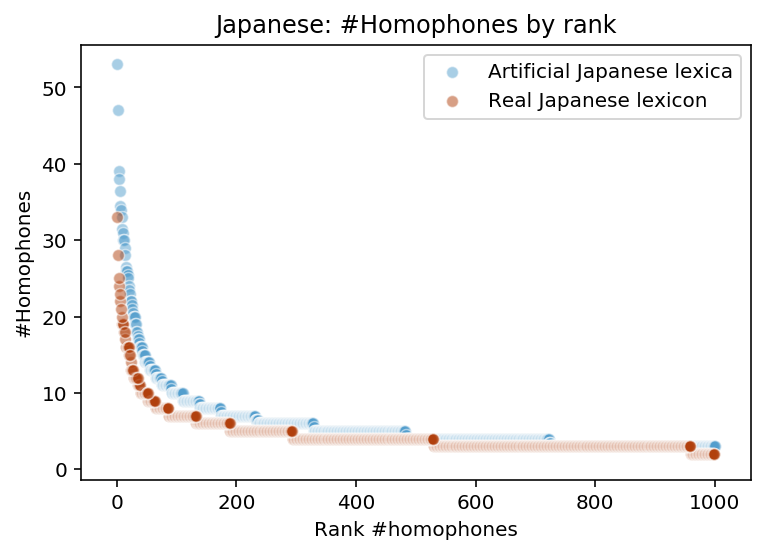

In [220]:
sns.scatterplot(data = df_stats,
               x = "rank_homophones",
               y = "num_homophones", 
                color = sns.color_palette("Blues")[3],
                alpha = .5,
                label = "Artificial Japanese lexica")

df_main_processed['rank_homophones'] = df_main_processed['num_homophones'].rank(ascending=False, method="first")
sns.scatterplot(data = df_main_processed[df_main_processed['rank_homophones']<rank_N],
               x = "rank_homophones",
               y = "num_homophones", 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real Japanese lexicon")
plt.xlabel("Rank #homophones")
plt.ylabel("#Homophones")
plt.title("Japanese: #Homophones by rank")

### Characterize power laws

#### Zipf

In [221]:
# df_main_processed['num_homophones'] = df_main_processed['num_homophones'].apply(lambda x: x + 1)

In [222]:
top_n = df_main_processed[df_main_processed['rank_homophones'] < rank_N]
x, y = top_n['rank_homophones'], top_n['num_homophones']

In [223]:
real_fit, real_preds = characterize_zipf_law(x, y, real=True)

Text(0, 0.5, 'Log(#homophones)')

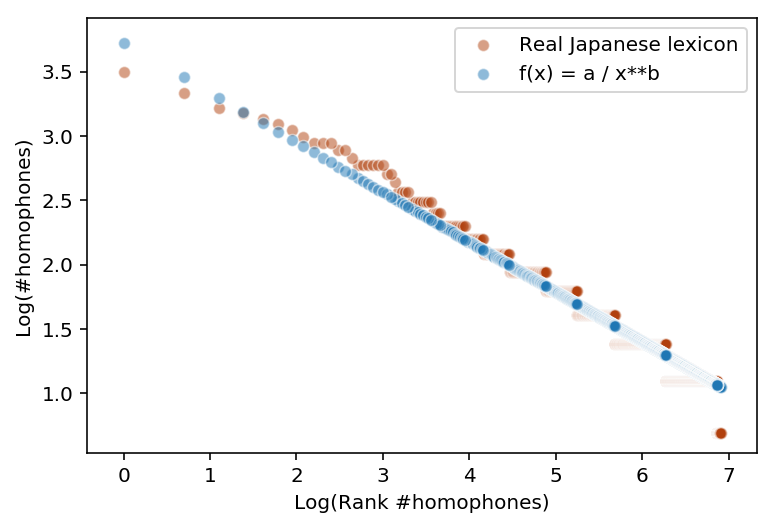

In [224]:
sns.scatterplot(x = [math.log(i) for i in x],
               y = [math.log(i) for i in y], 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real Japanese lexicon")

sns.scatterplot(x = [math.log(i) for i in x], 
                y = [math.log(i) for i in real_preds],
               alpha = .5,
               label = "f(x) = a / x**b")

plt.xlabel("Log(Rank #homophones)")
plt.ylabel("Log(#homophones)")

Text(0, 0.5, '#homophones')

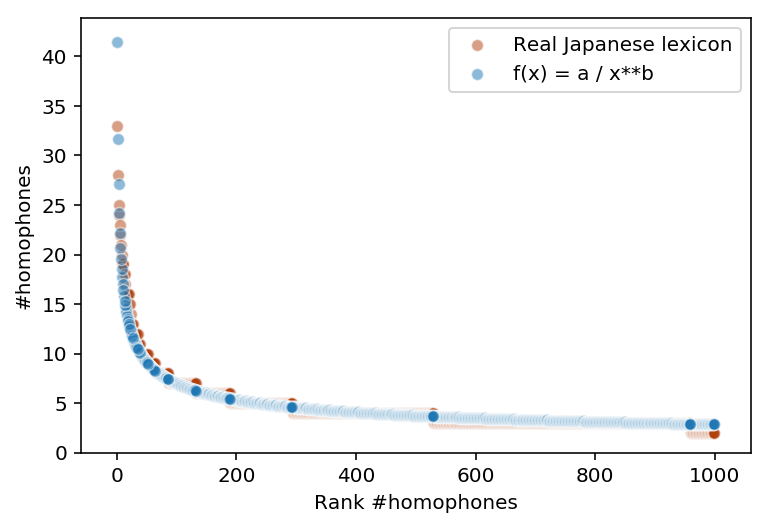

In [225]:
sns.scatterplot(x = x,
               y = y, 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real Japanese lexicon")

sns.scatterplot(x = x, 
                y = real_preds,
               alpha = .5,
               label = "f(x) = a / x**b")

plt.xlabel("Rank #homophones")
plt.ylabel("#homophones")

In [226]:
zipf_info = [real_fit]

In [227]:
for art in processed_artificials:
    top = art[art['rank_homophones'] < rank_N]
    x, y = top['rank_homophones'], top['num_homophones']
    fit, preds = characterize_zipf_law(x, y, real=False)
    zipf_info.append(fit)

In [228]:
df_fit = pd.DataFrame(zipf_info)

/Users/seantrott/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


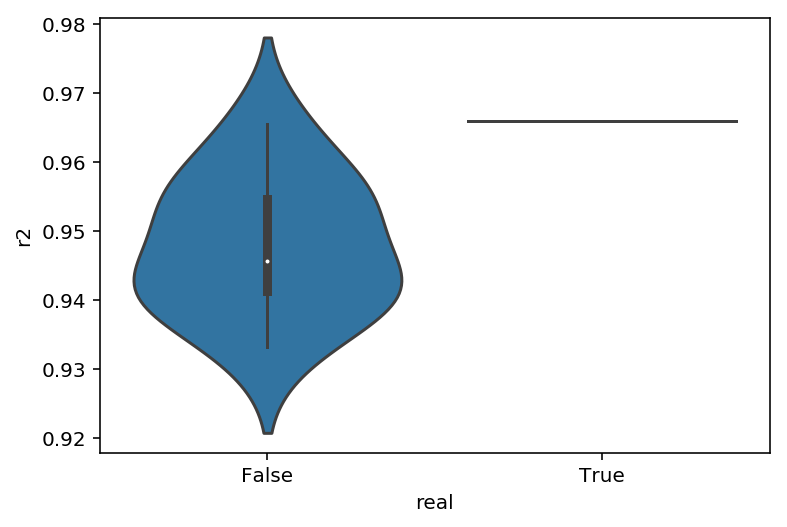

In [229]:
sns.violinplot(data = df_fit,
               x = 'real',
               y = 'r2')

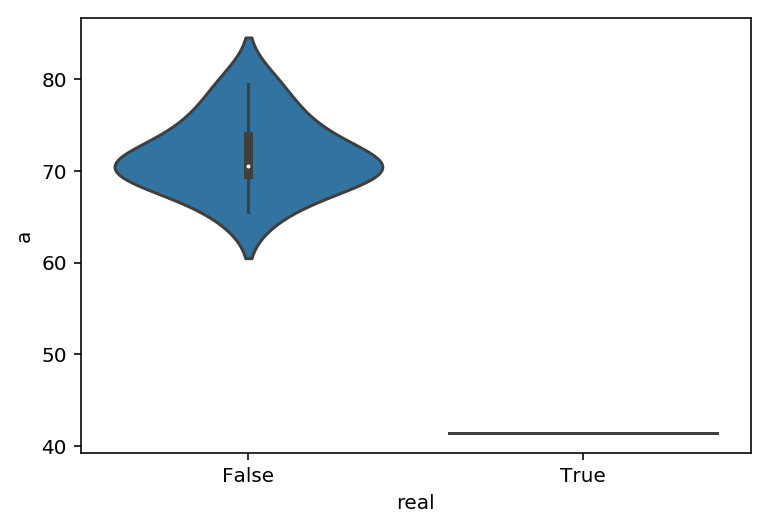

In [230]:
sns.violinplot(data = df_fit,
               x = 'real',
               y = 'a')

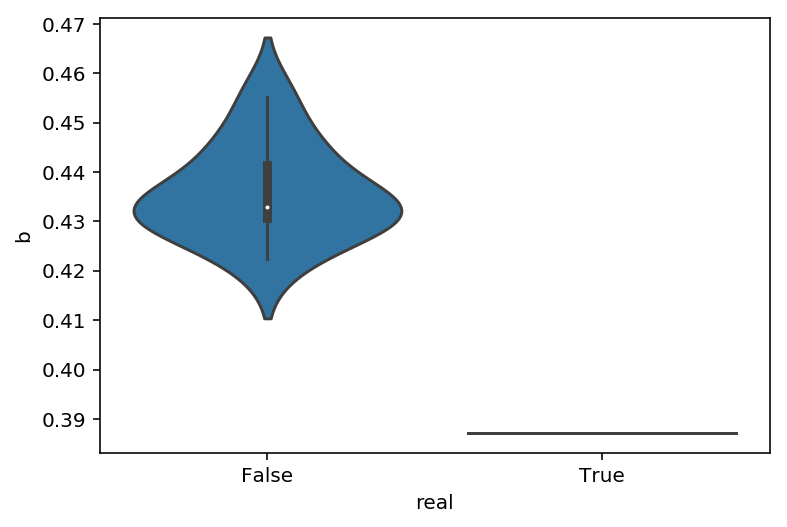

In [231]:
sns.violinplot(data = df_fit,
               x = 'real',
               y = 'b')

## `#minimal pairs ~ rank #minimal pairs`

In [232]:
rank_N = 1000

In [233]:
tops = []
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_mps'] = df_tmp_art['neighborhood_size'].rank(ascending=False, method="first")
    top_n = sorted(df_tmp_art[df_tmp_art['rank_mps']<=rank_N]['neighborhood_size'].values, reverse=True)
    tops.append(top_n)
stats = []
for n in range(rank_N):
    stats.append({
        'rank_mps': n + 1,
        'neighborhood_size': np.median([i[n] for i in tops])
    })
df_stats = pd.DataFrame(stats)

Text(0.5, 1.0, 'Japanese: #minimal pairs by rank')

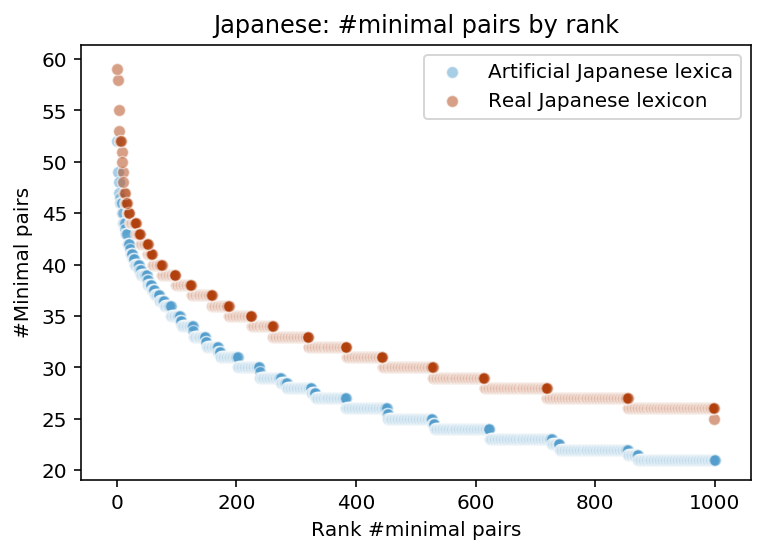

In [235]:
sns.scatterplot(data = df_stats,
               x = "rank_mps",
               y = "neighborhood_size", 
                color = sns.color_palette("Blues")[3],
                alpha = .5,
                label = "Artificial Japanese lexica")

df_main_processed['rank_mps'] = df_main_processed['neighborhood_size'].rank(ascending=False, method="first")
sns.scatterplot(data = df_main_processed[df_main_processed['rank_mps']<rank_N],
               x = "rank_mps",
               y = "neighborhood_size", 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real Japanese lexicon")
plt.xlabel("Rank #minimal pairs")
plt.ylabel("#Minimal pairs")
plt.title("Japanese: #minimal pairs by rank")

### Characterize power laws

#### Zipf

In [236]:
top_1000 = df_main_processed[df_main_processed['rank_mps'] < rank_N]
x, y = top_1000['rank_mps'], top_1000['neighborhood_size']

In [237]:
real_fit, real_preds = characterize_zipf_law(x, y, real=True)

Text(0, 0.5, 'Number of minimal pairs')

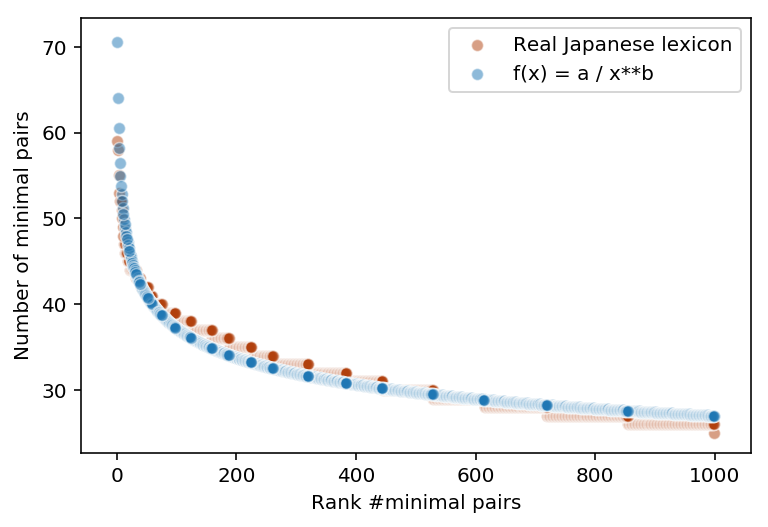

In [238]:
sns.scatterplot(x = x,
               y = y, 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real Japanese lexicon")

sns.scatterplot(x = x, 
                y = real_preds,
               alpha = .5,
               label = "f(x) = a / x**b")

plt.xlabel("Rank #minimal pairs")
plt.ylabel("Number of minimal pairs")

In [239]:
zipf_info = [real_fit]

In [240]:
for art in processed_artificials:
    top = art[art['rank_mps'] < rank_N]
    x, y = top['rank_mps'], top['neighborhood_size']
    fit, preds = characterize_zipf_law(x, y, real=False)
    zipf_info.append(fit)

In [241]:
df_fit = pd.DataFrame(zipf_info)

/Users/seantrott/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


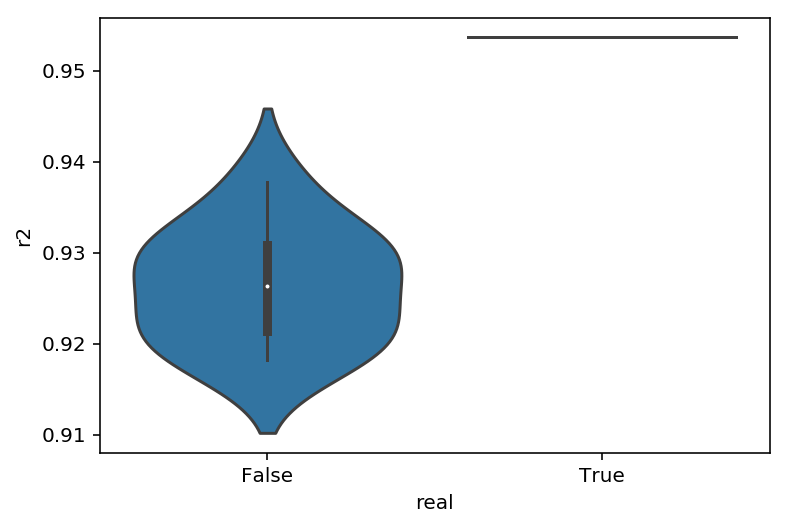

In [242]:
sns.violinplot(data = df_fit,
               x = 'real',
               y = 'r2')

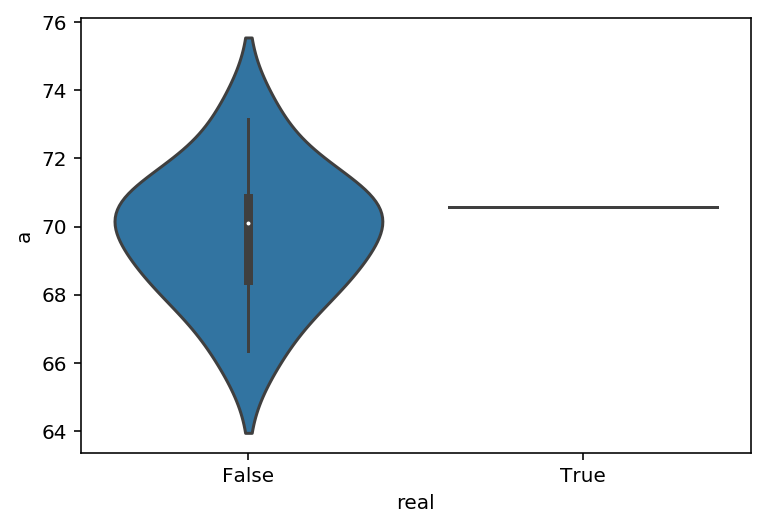

In [243]:
sns.violinplot(data = df_fit,
               x = 'real',
               y = 'a')

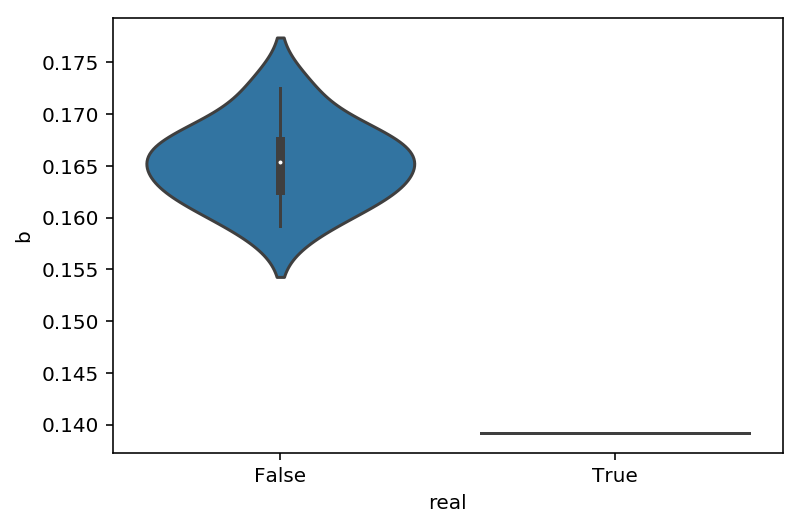

In [244]:
sns.violinplot(data = df_fit,
               x = 'real',
               y = 'b')

# Mandarin

In [245]:
df_main, df_main_processed, df_mandarin_artificials = load_lexicons_for_language("mandarin", word_column="word",
                                                                              phon_column="phonetic_remapped")

Number of tokens: 92880
Number of tokens: 92880
Number of tokens: 82924


In [248]:
info_for_mandarin = process_and_extract_artificials(df_mandarin_artificials, remove=False)
processed_artificials = info_for_mandarin['processed_dataframes']

100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


## `Frequency ~ rank_frequency`

Sanity check: this should follow Zipf's law.

In [252]:
df_main_processed['rank_frequency'] = df_main_processed['FreqPM'].rank(ascending=False, method="first")
df_main_processed = df_main_processed.sort_values(by = 'rank_frequency')

In [253]:
top_n = df_main_processed[df_main_processed['rank_frequency'] < rank_N]
x, y = top_n['rank_frequency'], top_n['FreqPM']

In [254]:
real_params, real_preds = characterize_zipf_law(x, y, real=True)

In [255]:
real_params

{'r2': 0.9174022044719455,
 'real': True,
 'a': 2.2004920692941474,
 'b': 0.7749359339169227}

Text(0, 0.5, 'Frequency')

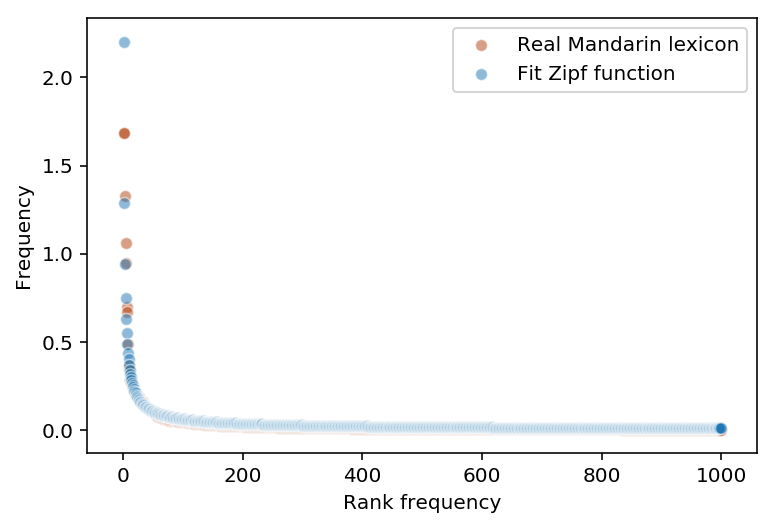

In [256]:
sns.scatterplot(x = x,
                y = y, 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real Mandarin lexicon")

sns.scatterplot(x = x, 
                y = real_preds,
                alpha = .5,
                label = "Fit Zipf function")

plt.xlabel("Rank frequency")
plt.ylabel("Frequency")

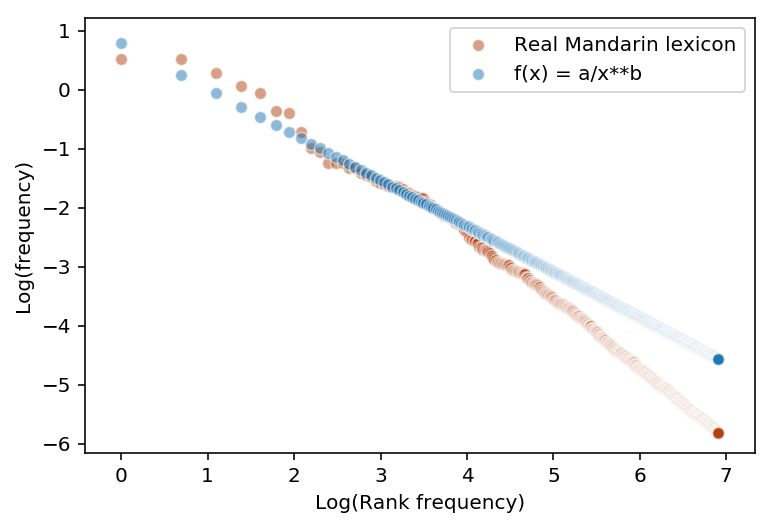

In [259]:
sns.scatterplot(x = [math.log(i) for i in x],
                y = [math.log(i) for i in y], 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real Mandarin lexicon")

sns.scatterplot(x = [math.log(i) for i in x], 
                y = [math.log(i) for i in real_preds],
                alpha = .5,
                label = "f(x) = a/x**b")

plt.xlabel("Log(Rank frequency)")
plt.ylabel("Log(frequency)")

plt.savefig("Figures/powerlaw/mandarin_zipf_frequency.png", dpi=300)

## `#homophones ~ rank_homophones`

In [260]:
rank_N = 1000

In [261]:
tops = []
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_homophones'] = df_tmp_art['num_homophones'].rank(ascending=False, method="first")
    top_n = sorted(df_tmp_art[df_tmp_art['rank_homophones']<=rank_N]['num_homophones'].values, reverse=True)
    tops.append(top_n)
stats = []
for n in range(rank_N):
    stats.append({
        'rank_homophones': n + 1,
        'num_homophones': np.median([i[n] for i in tops])
    })
df_stats = pd.DataFrame(stats)

Text(0.5, 1.0, 'Mandarin: #Homophones by rank')

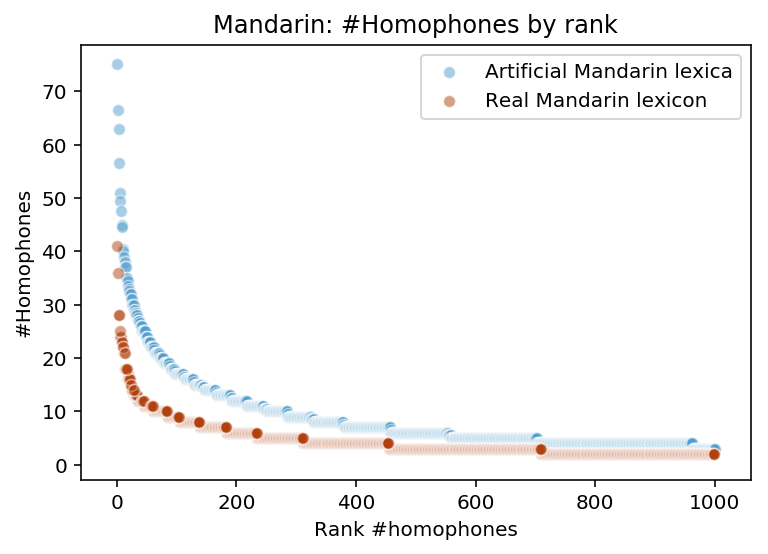

In [262]:
sns.scatterplot(data = df_stats,
               x = "rank_homophones",
               y = "num_homophones", 
                color = sns.color_palette("Blues")[3],
                alpha = .5,
                label = "Artificial Mandarin lexica")

df_main_processed['rank_homophones'] = df_main_processed['num_homophones'].rank(ascending=False, method="first")
sns.scatterplot(data = df_main_processed[df_main_processed['rank_homophones']<rank_N],
               x = "rank_homophones",
               y = "num_homophones", 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real Mandarin lexicon")
plt.xlabel("Rank #homophones")
plt.ylabel("#Homophones")
plt.title("Mandarin: #Homophones by rank")

### Characterize power laws

#### Zipf

In [263]:
# df_main_processed['num_homophones'] = df_main_processed['num_homophones'].apply(lambda x: x + 1)

In [264]:
top_n = df_main_processed[df_main_processed['rank_homophones'] < rank_N]
x, y = top_n['rank_homophones'], top_n['num_homophones']

In [265]:
real_fit, real_preds = characterize_zipf_law(x, y, real=True)

Text(0, 0.5, 'Log(#homophones)')

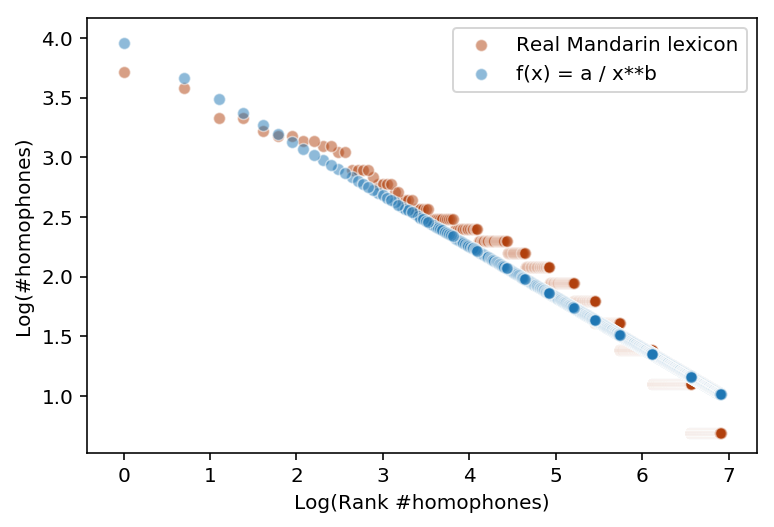

In [266]:
sns.scatterplot(x = [math.log(i) for i in x],
               y = [math.log(i) for i in y], 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real Mandarin lexicon")

sns.scatterplot(x = [math.log(i) for i in x], 
                y = [math.log(i) for i in real_preds],
               alpha = .5,
               label = "f(x) = a / x**b")

plt.xlabel("Log(Rank #homophones)")
plt.ylabel("Log(#homophones)")

Text(0, 0.5, '#homophones')

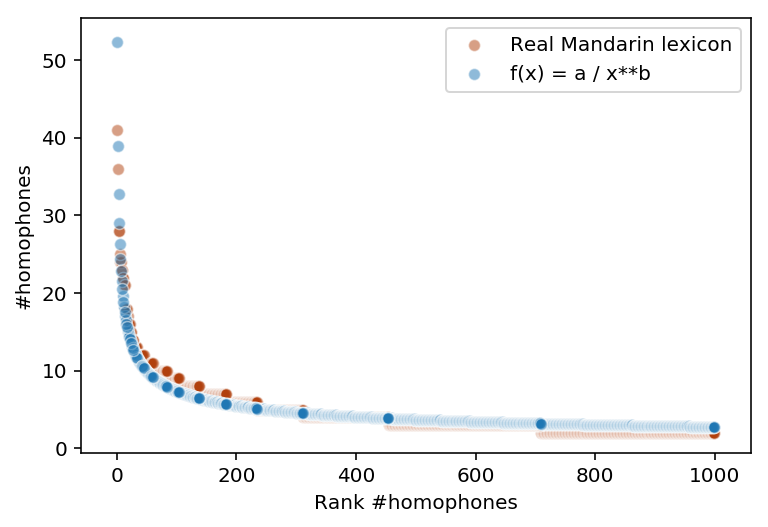

In [267]:
sns.scatterplot(x = x,
               y = y, 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real Mandarin lexicon")

sns.scatterplot(x = x, 
                y = real_preds,
               alpha = .5,
               label = "f(x) = a / x**b")

plt.xlabel("Rank #homophones")
plt.ylabel("#homophones")

In [268]:
zipf_info = [real_fit]

In [269]:
for art in processed_artificials:
    top = art[art['rank_homophones'] < rank_N]
    x, y = top['rank_homophones'], top['num_homophones']
    fit, preds = characterize_zipf_law(x, y, real=False)
    zipf_info.append(fit)

In [270]:
df_fit = pd.DataFrame(zipf_info)

/Users/seantrott/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


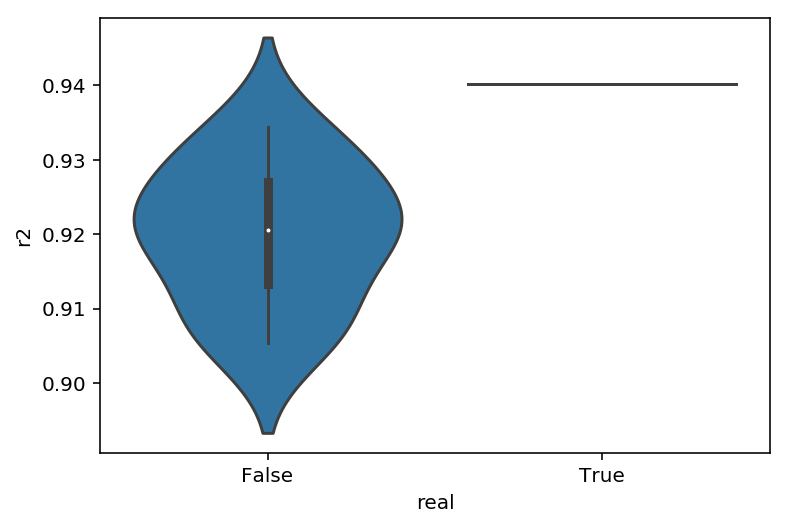

In [271]:
sns.violinplot(data = df_fit,
               x = 'real',
               y = 'r2')

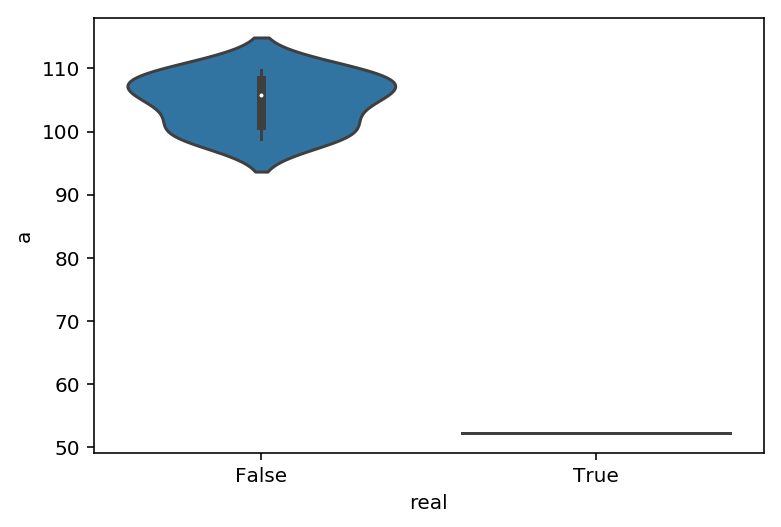

In [272]:
sns.violinplot(data = df_fit,
               x = 'real',
               y = 'a')

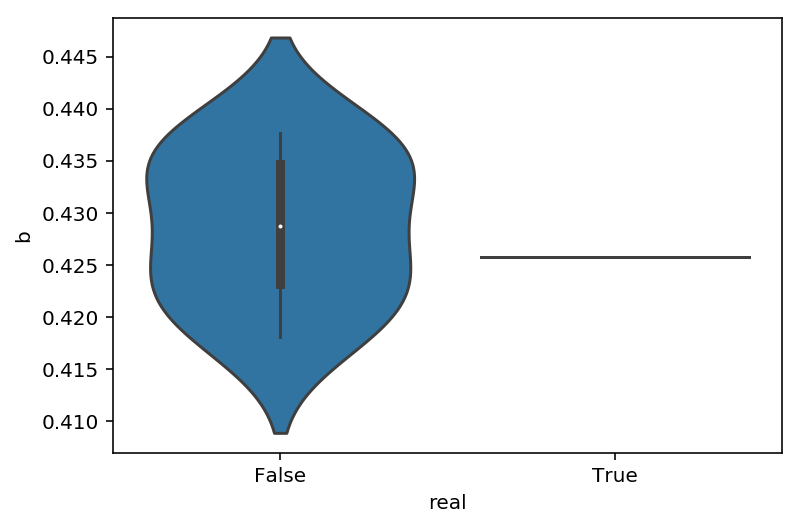

In [273]:
sns.violinplot(data = df_fit,
               x = 'real',
               y = 'b')

## `#minimal pairs ~ rank #minimal pairs`

In [274]:
rank_N = 1000

In [275]:
tops = []
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_mps'] = df_tmp_art['neighborhood_size'].rank(ascending=False, method="first")
    top_n = sorted(df_tmp_art[df_tmp_art['rank_mps']<=rank_N]['neighborhood_size'].values, reverse=True)
    tops.append(top_n)
stats = []
for n in range(rank_N):
    stats.append({
        'rank_mps': n + 1,
        'neighborhood_size': np.median([i[n] for i in tops])
    })
df_stats = pd.DataFrame(stats)

Text(0.5, 1.0, 'Mandarin: #minimal pairs by rank')

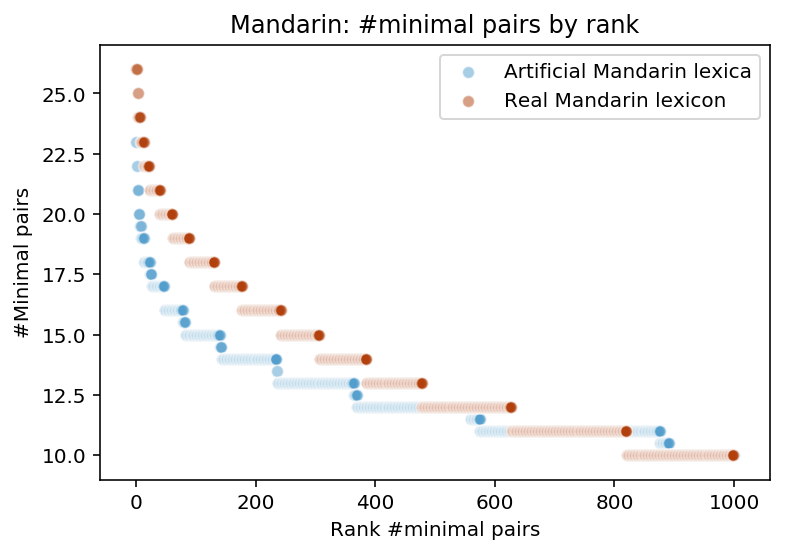

In [276]:
sns.scatterplot(data = df_stats,
               x = "rank_mps",
               y = "neighborhood_size", 
                color = sns.color_palette("Blues")[3],
                alpha = .5,
                label = "Artificial Mandarin lexica")

df_main_processed['rank_mps'] = df_main_processed['neighborhood_size'].rank(ascending=False, method="first")
sns.scatterplot(data = df_main_processed[df_main_processed['rank_mps']<rank_N],
               x = "rank_mps",
               y = "neighborhood_size", 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real Mandarin lexicon")
plt.xlabel("Rank #minimal pairs")
plt.ylabel("#Minimal pairs")
plt.title("Mandarin: #minimal pairs by rank")

### Characterize power laws

#### Zipf

In [277]:
top_1000 = df_main_processed[df_main_processed['rank_mps'] < rank_N]
x, y = top_1000['rank_mps'], top_1000['neighborhood_size']

In [278]:
real_fit, real_preds = characterize_zipf_law(x, y, real=True)

Text(0, 0.5, 'Number of minimal pairs')

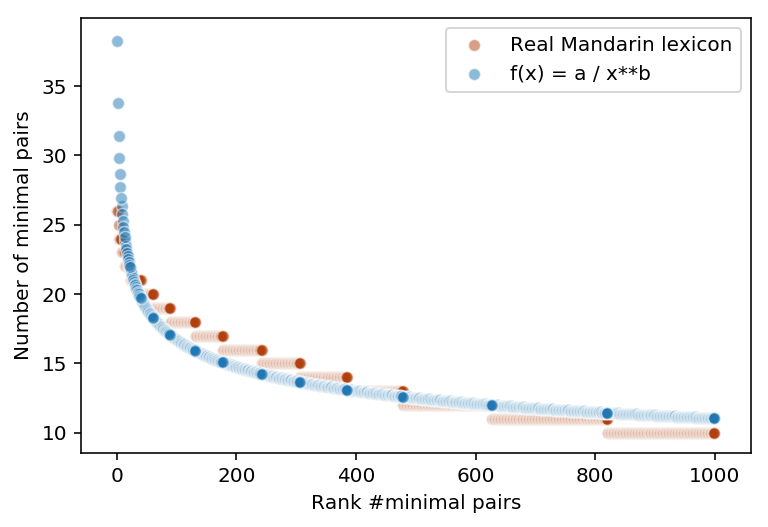

In [279]:
sns.scatterplot(x = x,
               y = y, 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real Mandarin lexicon")

sns.scatterplot(x = x, 
                y = real_preds,
               alpha = .5,
               label = "f(x) = a / x**b")

plt.xlabel("Rank #minimal pairs")
plt.ylabel("Number of minimal pairs")

In [280]:
zipf_info = [real_fit]

In [281]:
for art in processed_artificials:
    top = art[art['rank_mps'] < rank_N]
    x, y = top['rank_mps'], top['neighborhood_size']
    fit, preds = characterize_zipf_law(x, y, real=False)
    zipf_info.append(fit)

In [282]:
df_fit = pd.DataFrame(zipf_info)

/Users/seantrott/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


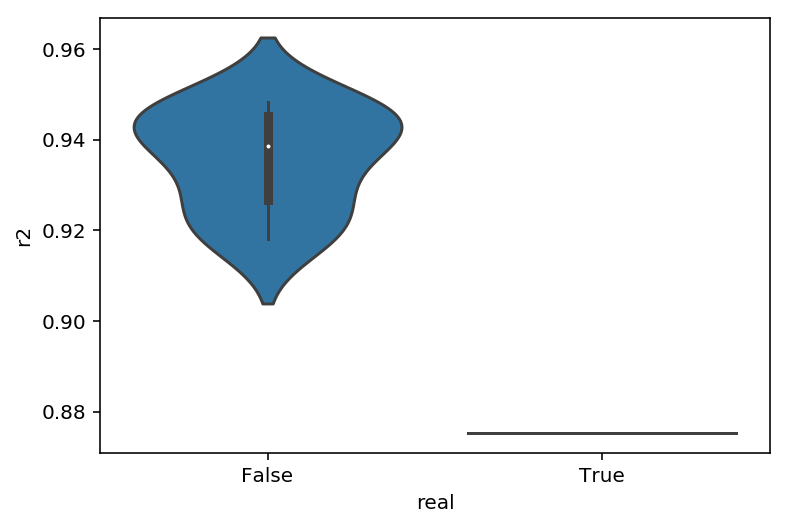

In [283]:
sns.violinplot(data = df_fit,
               x = 'real',
               y = 'r2')

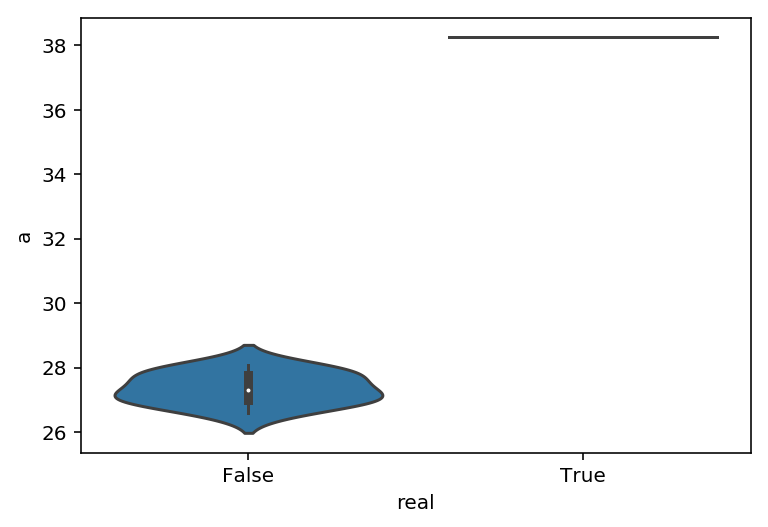

In [284]:
sns.violinplot(data = df_fit,
               x = 'real',
               y = 'a')

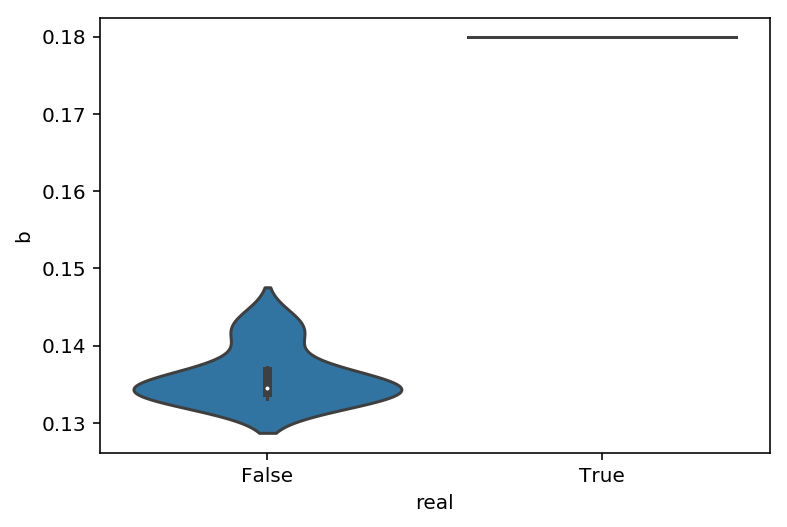

In [285]:
sns.violinplot(data = df_fit,
               x = 'real',
               y = 'b')

# All languages together

In [36]:
languages = ['english', 'german', 'dutch', 'french', 'japanese', 'mandarin']

In [37]:
fit_homophone_params = []
fit_neighborhood_params = []

In [38]:
rank_N = 1000

In [39]:
for language in languages:
    print(language)
    phon_column = config.PHON_COLUMN[language]
    word_column = config.WORD_COLUMN[language]
    df_main, df_main_processed, df_artificials = load_lexicons_for_language(language, phon_column=phon_column,
                                                                     word_column=word_column)
    
    # Process artificial lexica
    if language == "mandarin":
        language_info = process_and_extract_artificials(df_artificials, remove=False)
    else:
        language_info = process_and_extract_artificials(df_artificials, remove=True)
    processed_artificials = language_info.pop('processed_dataframes')
    
    #### Homophones
    
    # Fit Zipf to real homophone distribution
    df_main_processed['rank_homophones'] = df_main_processed['num_homophones'].rank(ascending=False, method="first")
    top_n = df_main_processed[df_main_processed['rank_homophones'] < rank_N]
    top_n = top_n.sort_values(by = "rank_homophones")
    x, y = top_n['rank_homophones'], top_n['num_homophones']
    
    ## Log (y+1) (add 1 to account for items with 0 homophones)
    y_log = [math.log(i+1) for i in y]
    
    real_fit, real_preds = characterize_zipf_law(x, y_log, real=True)
    real_fit['language'] = language
    fit_homophone_params.append(real_fit)
    
    # Fit Zipf to artificial minimal pair distribution    
    for art in processed_artificials:
        art['rank_homophones'] = art['num_homophones'].rank(ascending=False, method="first")
        top_n = art[art['rank_homophones'] < rank_N]
        top_n = top_n.sort_values(by = "rank_homophones")
        x, y = top_n['rank_homophones'], top_n['num_homophones']
        
        ## Log (y+1) (add 1 to account for items with 0 homophones)
        y_log = [math.log(i+1) for i in y]
        
        fit, preds = characterize_zipf_law(x, y_log, real=False)
        fit['language'] = language
        fit_homophone_params.append(fit)
        
        
    #### Minimal papirs
    
    # Fit Zipf to real minimal pair distribution
    df_main_processed['rank_mps'] = df_main_processed['neighborhood_size'].rank(ascending=False, method="first")
    top_n = df_main_processed[df_main_processed['rank_mps'] < rank_N]
    top_n = top_n.sort_values(by = "rank_mps")
    x, y = top_n['rank_mps'], top_n['neighborhood_size']
    
    ## Log (y+1) (add 1 to account for items with 0 mps)
    y_log = [math.log(i+1) for i in y]
    
    real_fit, real_preds = characterize_zipf_law(x, y_log, real=True)
    real_fit['language'] = language
    fit_neighborhood_params.append(real_fit)
    
    # Fit Zipf to artificial minimal pair distribution    
    for art in processed_artificials:
        art['rank_mps'] = art['neighborhood_size'].rank(ascending=False, method="first")
        top_n = art[art['rank_mps'] < rank_N]
        top_n = top_n.sort_values(by = "rank_mps")
        x, y = top_n['rank_mps'], top_n['neighborhood_size']
        
        ## Log (y+1) (add 1 to account for items with 0 mps)
        y_log = [math.log(i+1) for i in y]
        
        fit, preds = characterize_zipf_law(x, y_log, real=False)
        fit['language'] = language
        fit_neighborhood_params.append(fit)

english
Number of tokens: 52437
Number of tokens: 41887


/Users/seantrott/Dropbox/UCSD/Research/Ambiguity/Evolution/homophone_simulations/src/utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['remove'] = df[word_column].apply(remove_word)


Number of tokens: 35107


100%|██████████| 10/10 [00:08<00:00,  1.29it/s]


german
Number of tokens: 51718
Number of tokens: 51718


/Users/seantrott/Dropbox/UCSD/Research/Ambiguity/Evolution/homophone_simulations/src/utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['remove'] = df[word_column].apply(remove_word)


Number of tokens: 50474


100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


dutch
Number of tokens: 67910
Number of tokens: 67583
Number of tokens: 65351


100%|██████████| 10/10 [00:10<00:00,  1.02it/s]


french
Number of tokens: 47309
Number of tokens: 43782


/Users/seantrott/Dropbox/UCSD/Research/Ambiguity/Evolution/homophone_simulations/src/utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['remove'] = df[word_column].apply(remove_word)


Number of tokens: 37278


100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


japanese
Number of tokens: 51147
Number of tokens: 51147
Number of tokens: 40449


100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


mandarin
Number of tokens: 92880
Number of tokens: 92880
Number of tokens: 82924


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


## Homophone fits

In [40]:
df_homophone_fits = pd.DataFrame(fit_homophone_params)

In [41]:
df_homophone_fits.to_csv("data/fits/homophone_fits.csv")

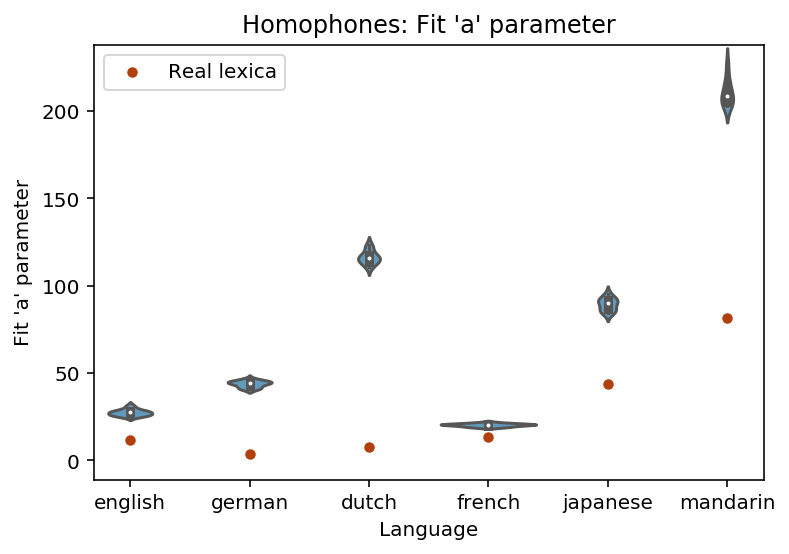

In [49]:
sns.violinplot(data = df_homophone_fits[df_homophone_fits['real']==False],
               x = "language",
               y = 'a',
               color = sns.color_palette("Blues")[3],
               # order = ['english', 'german', 'dutch', 'french', 'japanese', 'mandarin'],
               label = "Simulated")

sns.scatterplot(data = df_homophone_fits[df_homophone_fits['real']==True],
              x = "language",
              y = 'a',
              color = sns.color_palette("dark")[1],
              # join = False,
              label = "Real lexica")

plt.ylabel("Fit 'a' parameter")
plt.xlabel("Language")
plt.title("Homophones: Fit 'a' parameter")

plt.savefig("Figures/powerlaw/homophones_fit_a_parameter.png", dpi=300)

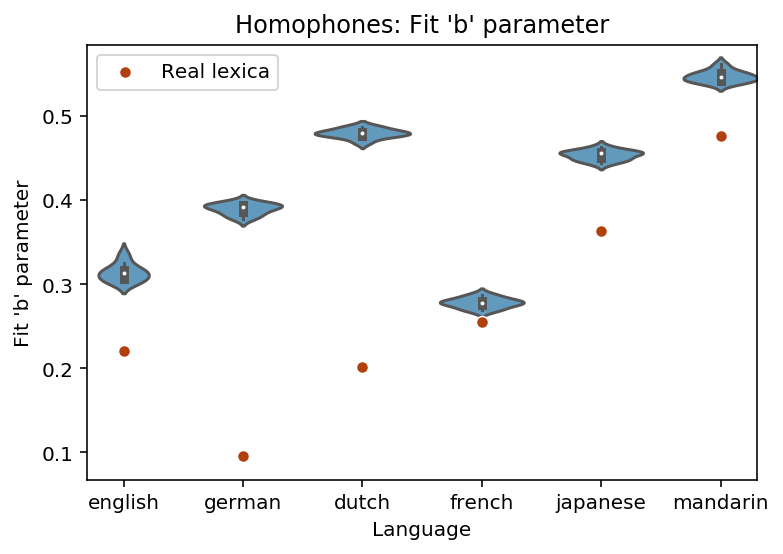

In [48]:
sns.violinplot(data = df_homophone_fits[df_homophone_fits['real']==False],
               x = "language",
               y = 'b',
               color = sns.color_palette("Blues")[3],
               # order = ['english', 'german', 'dutch', 'french', 'japanese', 'mandarin'],
               label = "Simulated")

sns.scatterplot(data = df_homophone_fits[df_homophone_fits['real']==True],
              x = "language",
              y = 'b',
              color = sns.color_palette("dark")[1],
              # join = False,
              label = "Real lexica")

plt.ylabel("Fit 'b' parameter")
plt.xlabel("Language")

plt.title("Homophones: Fit 'b' parameter")

plt.savefig("Figures/powerlaw/homophones_fit_b_parameter.png", dpi=300)

Text(0.5, 0, 'Language')

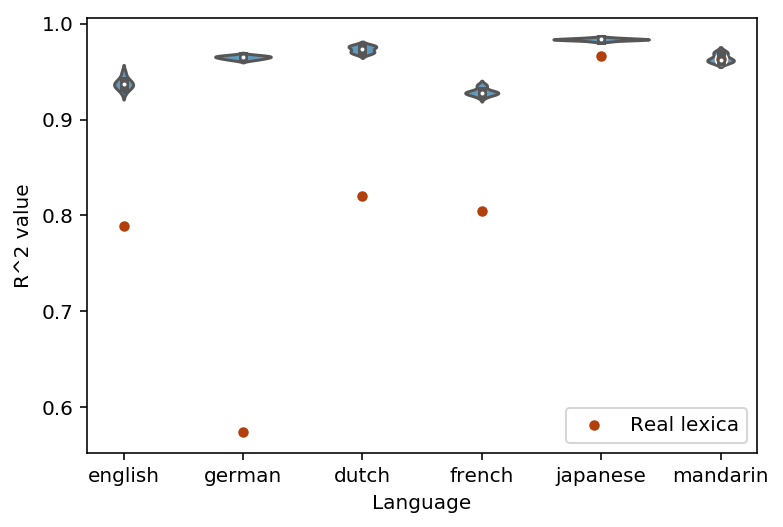

In [39]:
sns.violinplot(data = df_homophone_fits[df_homophone_fits['real']==False],
               x = "language",
               y = 'r2',
               color = sns.color_palette("Blues")[3],
               # order = ['english', 'german', 'dutch', 'french', 'japanese', 'mandarin'],
               label = "Simulated")

sns.scatterplot(data = df_homophone_fits[df_homophone_fits['real']==True],
              x = "language",
              y = 'r2',
              color = sns.color_palette("dark")[1],
              # join = False,
              label = "Real lexica")

plt.ylabel("R^2 value")
plt.xlabel("Language")

## Minimal pair fits

In [50]:
df_neighborhood_fits = pd.DataFrame(fit_neighborhood_params)

In [51]:
df_neighborhood_fits.to_csv("data/fits/neighborhood_fits.csv")

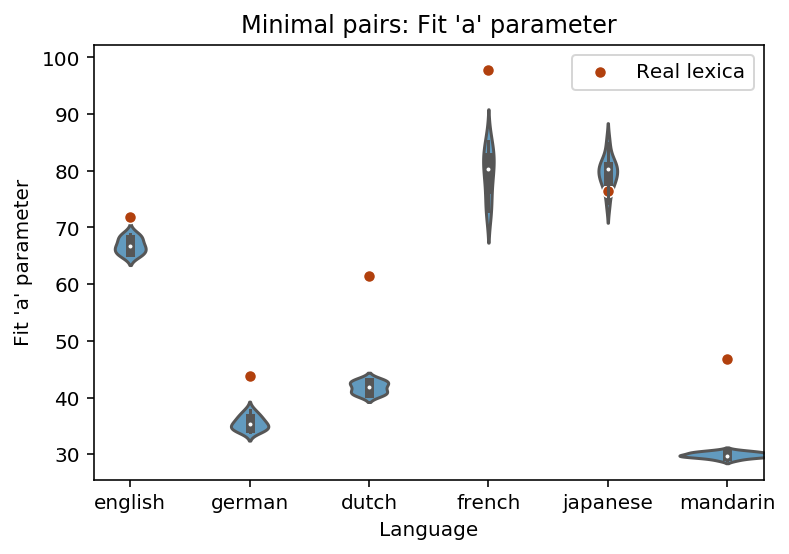

In [53]:
sns.violinplot(data = df_neighborhood_fits[df_neighborhood_fits['real']==False],
               x = "language",
               y = 'a',
               color = sns.color_palette("Blues")[3],
               # order = ['english', 'german', 'dutch', 'french', 'japanese', 'mandarin'],
               label = "Simulated")

sns.scatterplot(data = df_neighborhood_fits[df_neighborhood_fits['real']==True],
              x = "language",
              y = 'a',
              color = sns.color_palette("dark")[1],
              # join = False,
              label = "Real lexica")

plt.ylabel("Fit 'a' parameter")
plt.xlabel("Language")


plt.title("Minimal pairs: Fit 'a' parameter")

plt.savefig("Figures/powerlaw/mps_fit_a_parameter.png", dpi=300)

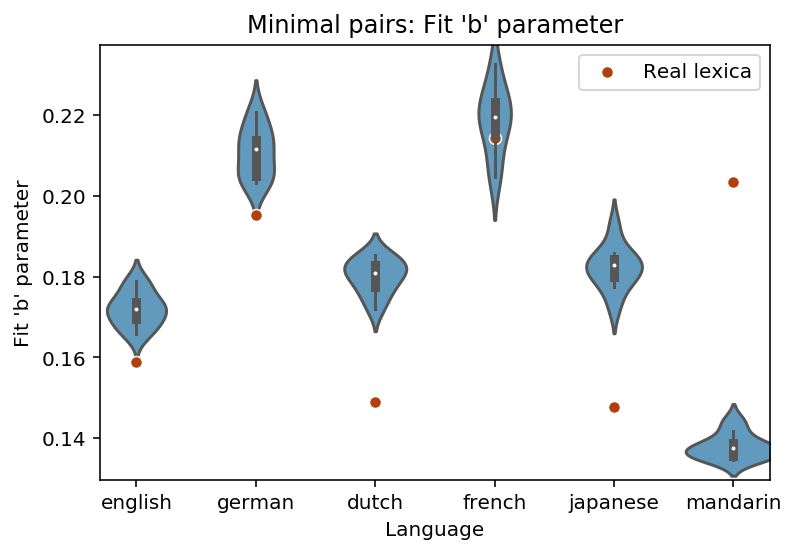

In [54]:
sns.violinplot(data = df_neighborhood_fits[df_neighborhood_fits['real']==False],
               x = "language",
               y = 'b',
               color = sns.color_palette("Blues")[3],
               # order = ['english', 'german', 'dutch', 'french', 'japanese', 'mandarin'],
               label = "Simulated")

sns.scatterplot(data = df_neighborhood_fits[df_neighborhood_fits['real']==True],
              x = "language",
              y = 'b',
              color = sns.color_palette("dark")[1],
              # join = False,
              label = "Real lexica")

plt.ylabel("Fit 'b' parameter")
plt.xlabel("Language")

plt.title("Minimal pairs: Fit 'b' parameter")

plt.savefig("Figures/powerlaw/mps_fit_b_parameter.png", dpi=300)

Text(0.5, 0, 'Language')

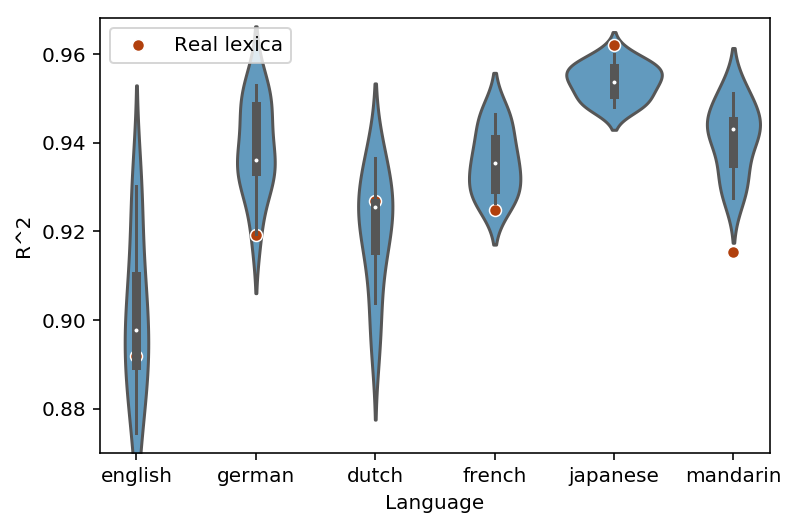

In [44]:
sns.violinplot(data = df_neighborhood_fits[df_neighborhood_fits['real']==False],
               x = "language",
               y = 'r2',
               color = sns.color_palette("Blues")[3],
               # order = ['english', 'german', 'dutch', 'french', 'japanese', 'mandarin'],
               label = "Simulated")

sns.scatterplot(data = df_neighborhood_fits[df_neighborhood_fits['real']==True],
              x = "language",
              y = 'r2',
              color = sns.color_palette("dark")[1],
              # join = False,
              label = "Real lexica")

plt.ylabel("R^2")
plt.xlabel("Language")